In [2]:
from diffusers import DDPMPipeline

100%|██████████| 25/25 [00:01<00:00, 16.42it/s]


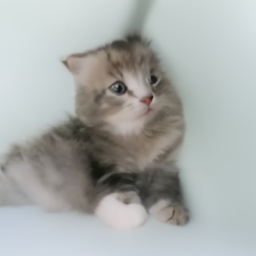

In [33]:

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

image = ddpm(num_inference_steps=25).images[0]

image

In [34]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [38]:
scheduler.set_timesteps(50)
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [41]:
import torch

sample_size = model.config.sample_size

noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
print(sample_size)
print(noise.shape)

256
torch.Size([1, 3, 256, 256])


In [42]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

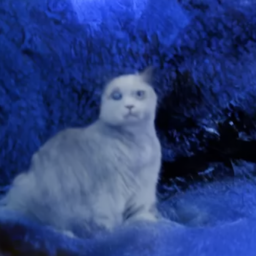

In [43]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

100%|██████████| 50/50 [00:03<00:00, 16.19it/s]


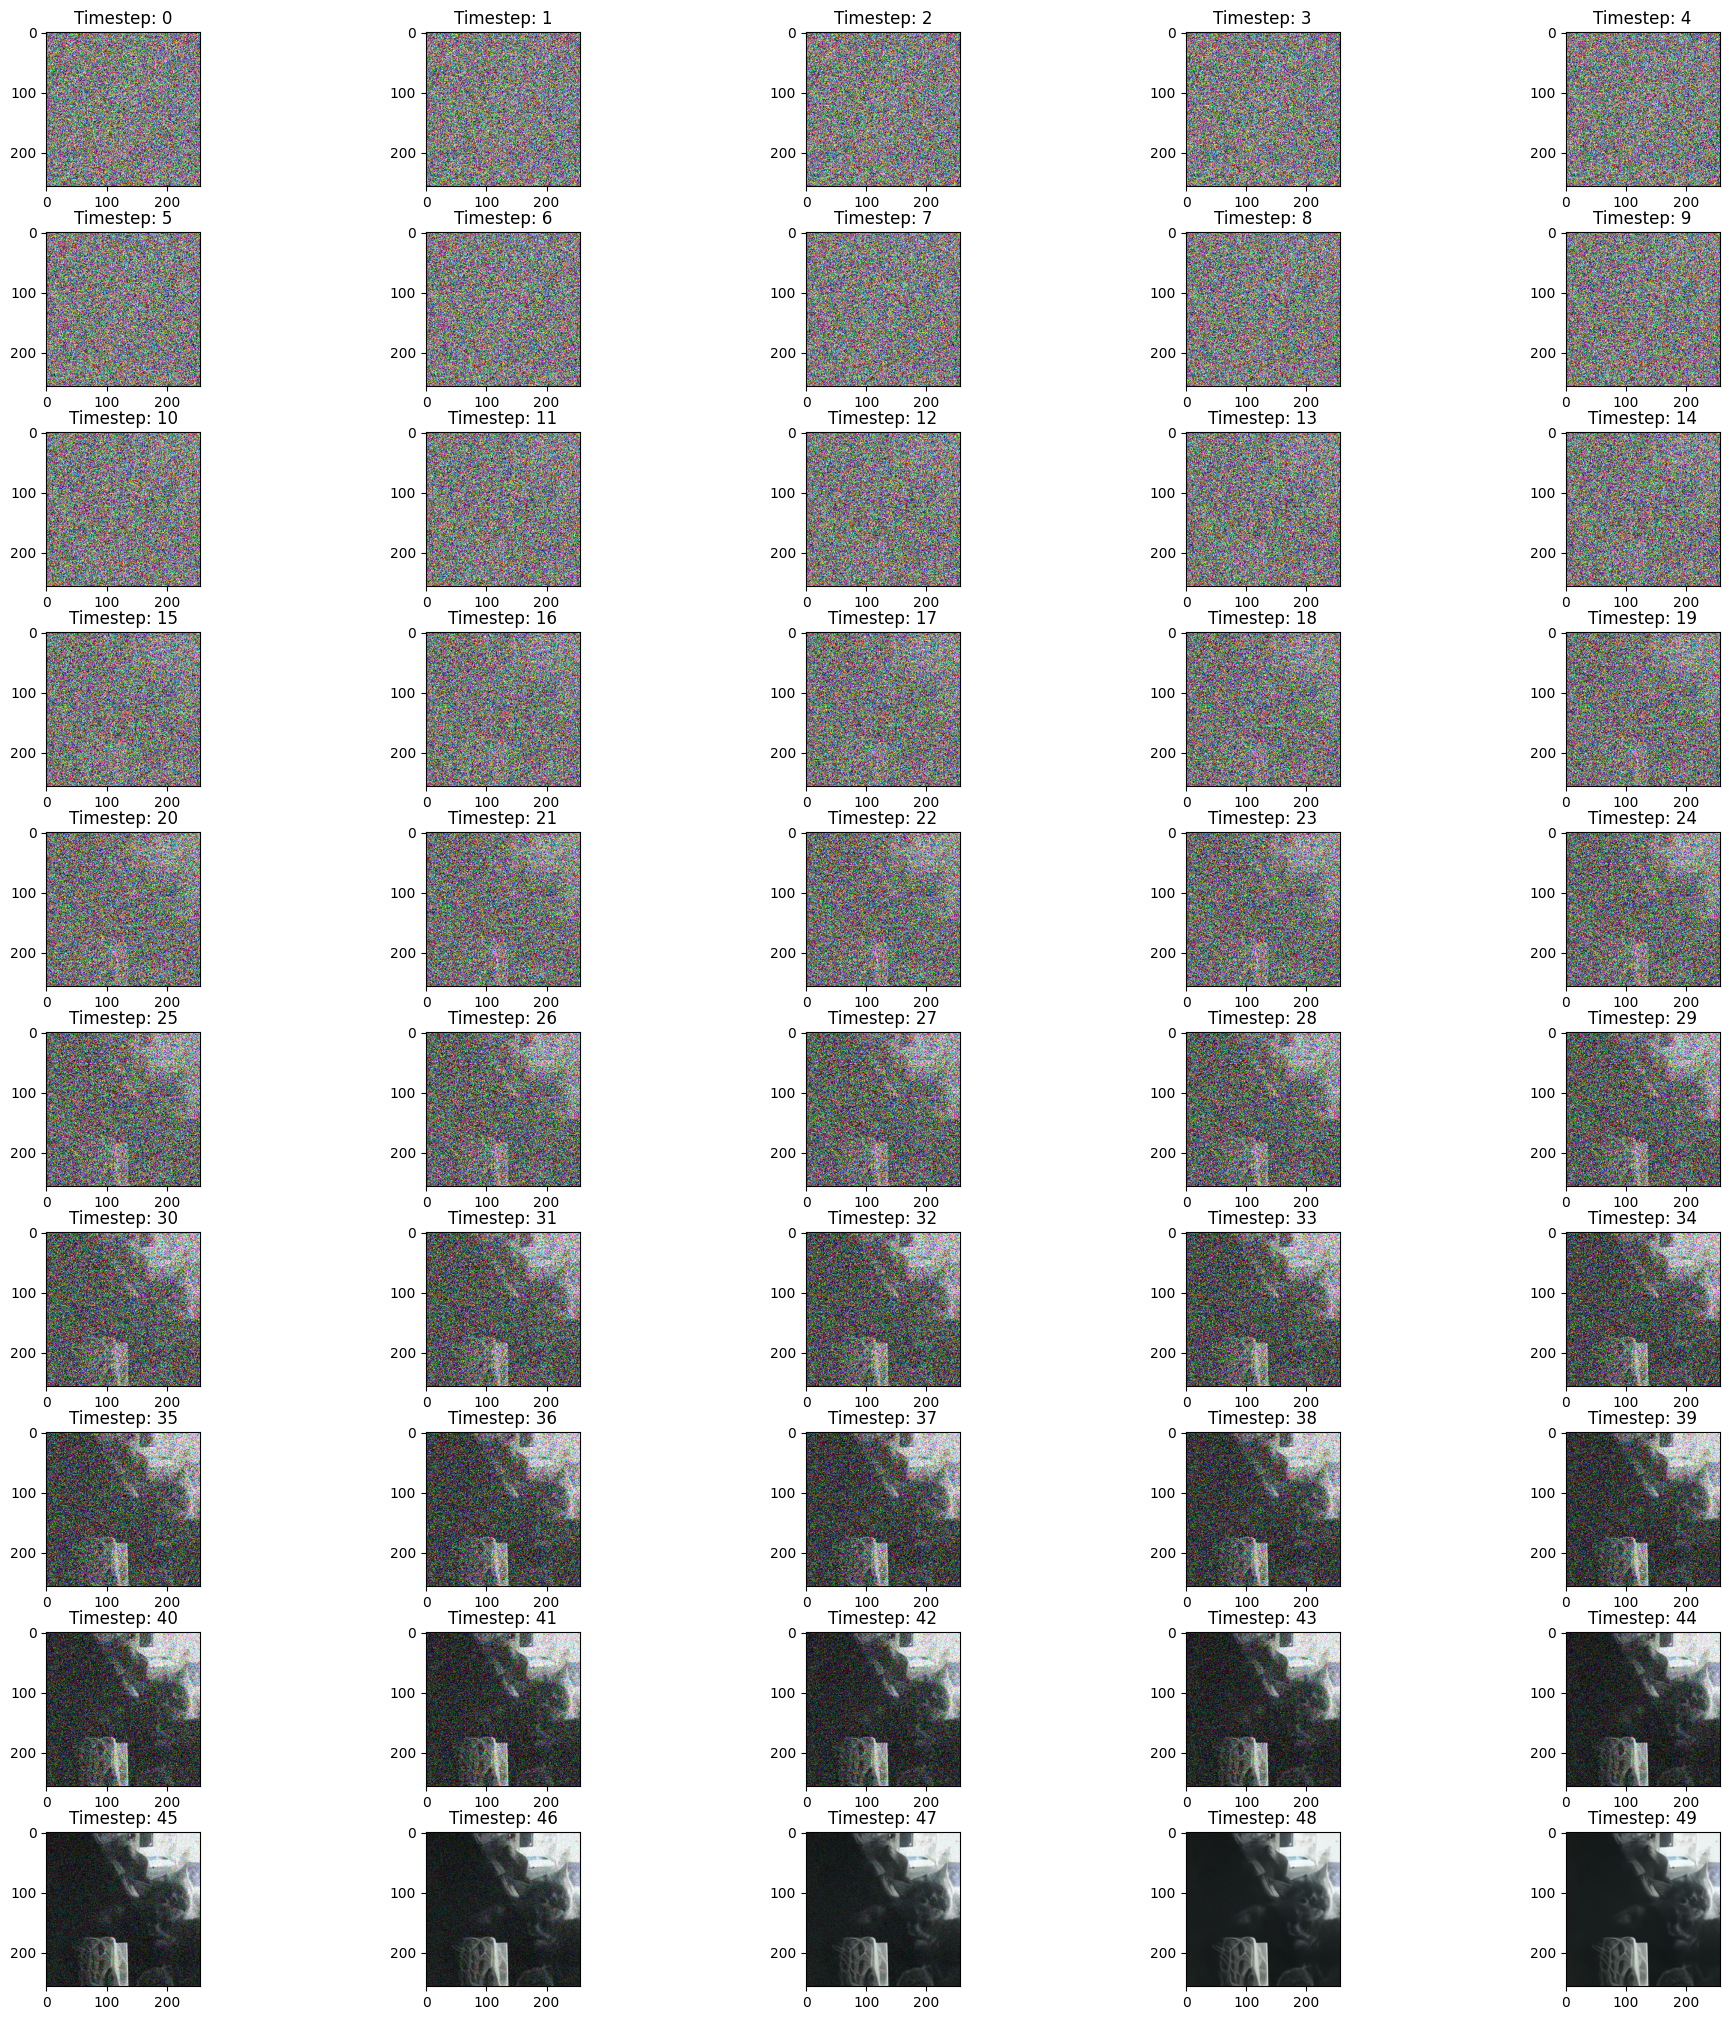

In [60]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm  # Import tqdm

input = noise
num_images = len(scheduler.timesteps)
num_cols = 5  # You can adjust this value
num_rows = num_images // num_cols if num_images % num_cols == 0 else num_images // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))  # You can adjust the figure size

# Wrap scheduler.timesteps with tqdm()
for i, t in enumerate(tqdm(scheduler.timesteps)):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

    # Convert the tensor to an image
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)

    # Display the image
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(image)
    axs[row, col].set_title(f'Timestep: {i}')  # Add timestep to the plot label

plt.tight_layout(pad=0)
plt.show()